In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np 
import matplotlib.pyplot as plt 
from apdist.distances import AmplitudePhaseDistance as dist

optim_kwargs = {"optim":"DP", "grid_dim":10}
from activephasemap.simulators import UVVisExperiment

In [3]:
design_space_bounds = [(0.0, 35.0), (0.0, 35.0)]
expt = UVVisExperiment(design_space_bounds, "../data/")
expt.read_iter_data(14)
expt.generate(use_spline=True)

Loading data from iteration 0 with shapes: (12, 2) (12, 101)
Loading data from iteration 1 with shapes: (6, 2) (6, 101)
Loading data from iteration 2 with shapes: (6, 2) (6, 101)
Loading data from iteration 3 with shapes: (6, 2) (6, 101)
Loading data from iteration 4 with shapes: (6, 2) (6, 101)
Loading data from iteration 5 with shapes: (6, 2) (6, 101)
Loading data from iteration 6 with shapes: (6, 2) (6, 101)
Loading data from iteration 7 with shapes: (6, 2) (6, 101)
Loading data from iteration 8 with shapes: (6, 2) (6, 101)
Loading data from iteration 9 with shapes: (6, 2) (6, 101)
Loading data from iteration 10 with shapes: (6, 2) (6, 101)
Loading data from iteration 11 with shapes: (6, 2) (6, 101)
Loading data from iteration 12 with shapes: (6, 2) (6, 101)
Loading data from iteration 13 with shapes: (6, 2) (6, 101)


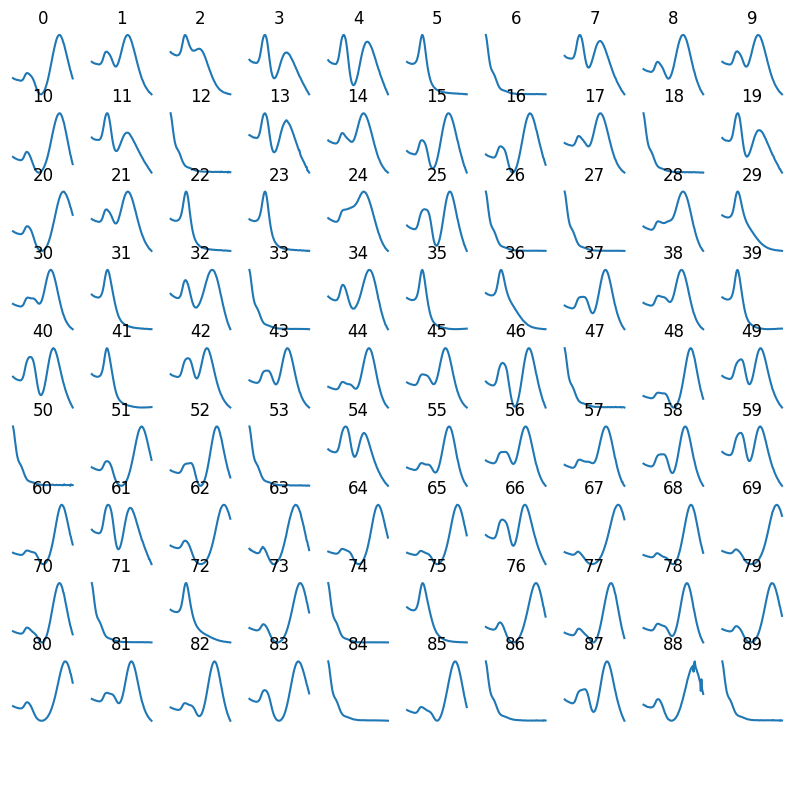

In [4]:
fig, axs = plt.subplots(10,10, figsize=(10,10))
for i, ax in enumerate(axs.flatten()):
    if not (i+1)>expt.comps.shape[0]:
        ax.plot(expt.wl, expt.spectra_normalized[i,:])
        ax.set_title("%d"%i)
    ax.axis("off")
plt.show()

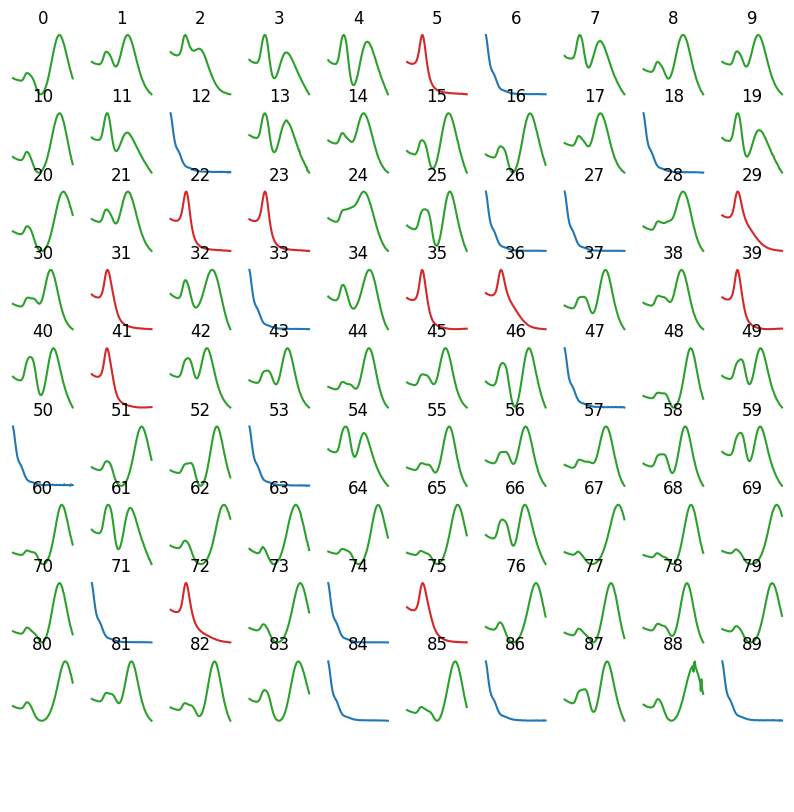

In [5]:
# get features
from scipy.signal import find_peaks

def featurize(x,y):
    "Use peak locations to determine morphology"
    peaks, _ = find_peaks(y, prominence=0.01, width=0.3)
    if len(peaks)==0:
        shape = 0
    elif (x[peaks]>600).any():
        shape = 2
    elif not (x[peaks]>600).any():
        shape = 1
        
    return shape

phase_colors =['tab:blue','tab:red','tab:green']
fig, axs = plt.subplots(10,10, figsize=(10,10))
for i, ax in enumerate(axs.flatten()):
    if not (i+1)>expt.comps.shape[0]:
        feats = featurize(expt.wl, expt.spectra_normalized[i,:])
        ax.plot(expt.wl, expt.spectra_normalized[i,:], c=phase_colors[int(feats)])
        ax.set_title("%d"%i)
    ax.axis("off")
plt.show()


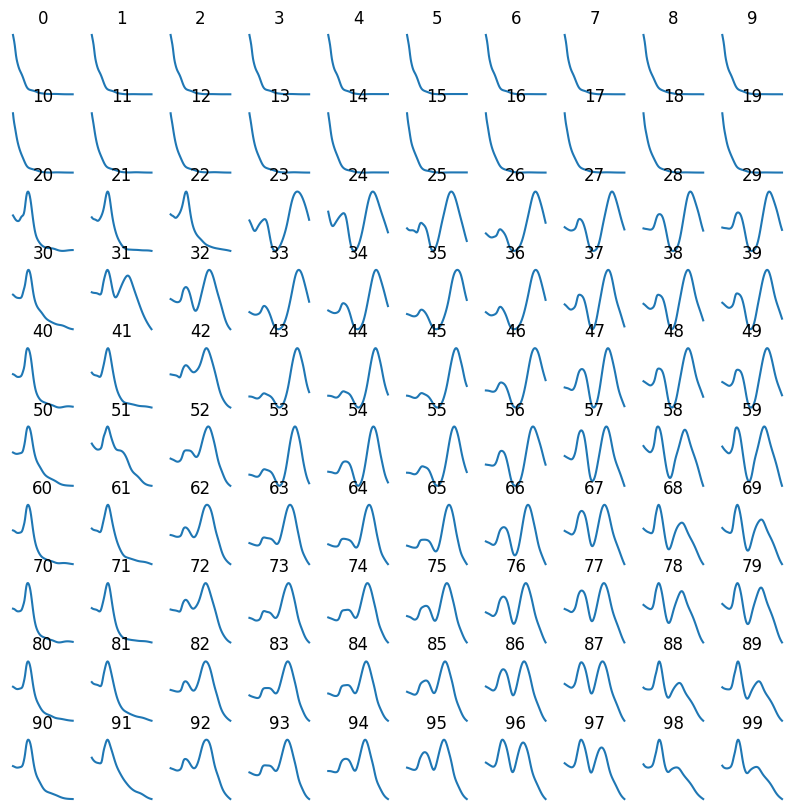

In [7]:
grid_data = np.load("../paper/data/grid_data_10_14.npz")
fig, axs = plt.subplots(10,10, figsize=(10,10))
for i, ax in enumerate(axs.flatten()):
    if not (i+1)>grid_data["comps"].shape[0]:
        ax.plot(expt.wl, grid_data["spectra"][i,:,0])
        ax.set_title("%d"%i)
    ax.axis("off")
plt.show()

In [22]:
from lmfit.models import GaussianModel

def fit_gaussian_curve(x, y, num_gaussians=1):
    """
    Fits Gaussian functions to a given curve and provides a smooth approximation.

    Parameters:
        x (np.ndarray): Array of x values.
        y (np.ndarray): Array of y values (noisy curve).
        num_gaussians (int): Number of Gaussian functions to fit.

    Returns:
        tuple: (fitted_y, result), where:
            - fitted_y (np.ndarray): Smoothed curve from the fitted Gaussian functions.
            - result (lmfit.model.ModelResult): The fit result containing parameters and statistics.
    """
    model = None
    params = None

    for i in range(num_gaussians):
        gaussian = GaussianModel(prefix=f"g{i}_")
        if model is None:
            model = gaussian
            params = gaussian.guess(y, x=x)
        else:
            model += gaussian
            params.update(gaussian.guess(y, x=x))
    
    result = model.fit(y, params, x=x)
    fitted_y = result.best_fit
    return fitted_y, result

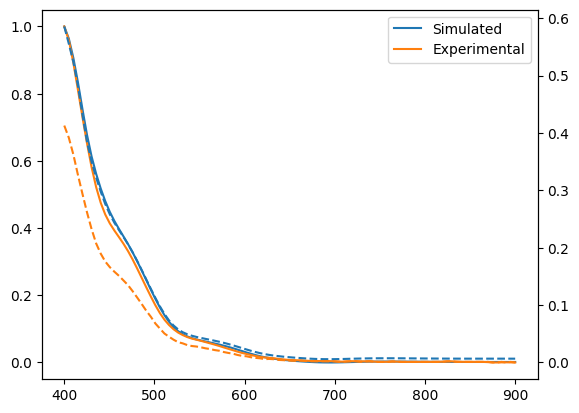

In [23]:
from scipy.signal import savgol_filter
from scipy.ndimage import gaussian_filter
from scipy.interpolate import UnivariateSpline

def smoothen(y, mode="savgol", **kwargs):
    if mode=="savgol_filter":
        # example : {"mode" : "savgol_filter", "window_length" : 51, "polyorder" : 7}
        y_hat = savgol_filter(y, **kwargs)
    elif mode=="gauss_filter":
        # example : {"mode" : "gauss_filter", "sigma" : 3.0}
        y_hat = gaussian_filter(y,  **kwargs)
    elif mode=="spline":
        # example : {"mode" : "spline", "s" : 1e-2}
        spline = UnivariateSpline(expt.t, y,  **kwargs)
        y_hat = spline(expt.t)
    elif mode=="gauss_fit":
        # example : {"mode" : "gauss_fit", "num_gaussians" : 1}
        y_hat, _ = fit_gaussian_curve(expt.t, y, **kwargs)

    y_hat = (y_hat-min(y_hat))/(max(y_hat)-min(y_hat))
    return y_hat 

f_sim = grid_data["spectra"][6,:,0]
f_expt = expt.spectra_normalized[6,:]
smoothen_kwargs = {"mode" : "gauss_filter", "sigma" : 1.0}
fig, ax = plt.subplots()
ax2 = ax.twinx()

f_query = smoothen(f_sim, **smoothen_kwargs)
line, = ax.plot(expt.wl, f_query, label="Simulated")
ax2.plot(expt.wl, f_sim, color=line.get_color(), ls='--')

f_ref = smoothen(f_expt, **smoothen_kwargs)
line, = ax.plot(expt.wl, f_ref, label="Experimental")
ax2.plot(expt.wl, f_expt, color=line.get_color(), ls='--')

ax.legend()
plt.show()

(0.0, 0.02)

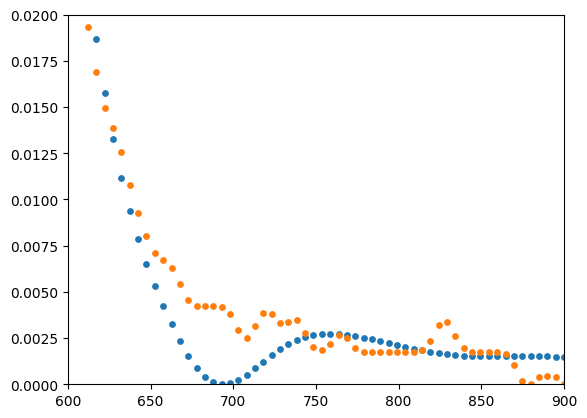

In [24]:
plt.scatter(expt.wl, f_query, s=15)
plt.scatter(expt.wl, f_ref, s=15)
plt.xlim([600, 900])
plt.ylim([0.0, 0.02])

Amplitude: 0.10 Phase: 0.41


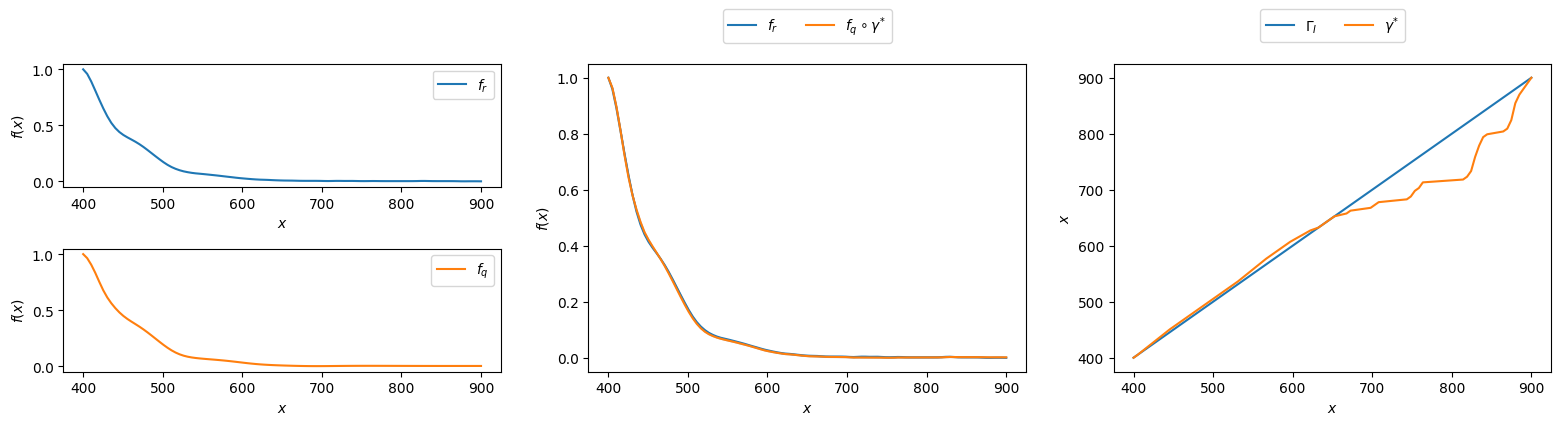

In [25]:
# Plot warped functions and gamma 
from apdist.utils import plot_warping 
from apdist.geometry import SquareRootSlopeFramework as SRSF

amplitude, phase = dist(expt.t, f_ref, f_query, **optim_kwargs)
print("Amplitude: %.2f Phase: %.2f"%(amplitude, phase))
# for SRSF representation, we map the domain into [0,1]
srsf = SRSF(expt.t)
q_ref = srsf.to_srsf(f_ref)
q_query = srsf.to_srsf(f_query)
gamma = srsf.get_gamma(q_ref, q_query, **optim_kwargs)
f_query_gamma = srsf.warp_f_gamma(f_query, gamma)
plot_warping(expt.wl, f_ref, f_query, f_query_gamma, gamma)
plt.show()

In [26]:
# Try weighted phase distance
srsf = SRSF(expt.t)
q_ref = srsf.to_srsf(f_ref)
q_query = srsf.to_srsf(f_query)
gamma = srsf.get_gamma(q_ref, q_query, **optim_kwargs)

delta = q_ref-q_query
if delta.sum() == 0:
    dist = 0
else:
    gam_dev = np.gradient(gamma, srsf.time)
    q_gamma = np.interp(gamma, srsf.time, q_query)
    y_amplitude = (q_ref - (q_gamma * np.sqrt(gam_dev))) ** 2

    amplitude = np.sqrt(np.trapz(y_amplitude, srsf.time))

    p_gamma = np.sqrt(gam_dev)*f_ref # we define p(\gamma) = \sqrt{\dot{\gamma(t)}} * f(t)
    p_identity = np.ones_like(gam_dev)*f_ref
    y_phase =  (p_gamma - p_identity) ** 2

    phase = np.sqrt(np.trapz(y_phase, srsf.time))

print("Amplitude: %.2f Phase: %.2f"%(amplitude, phase))

Amplitude: 0.10 Phase: 0.01


Amplitude : 0.1192, Phase : 0.4447


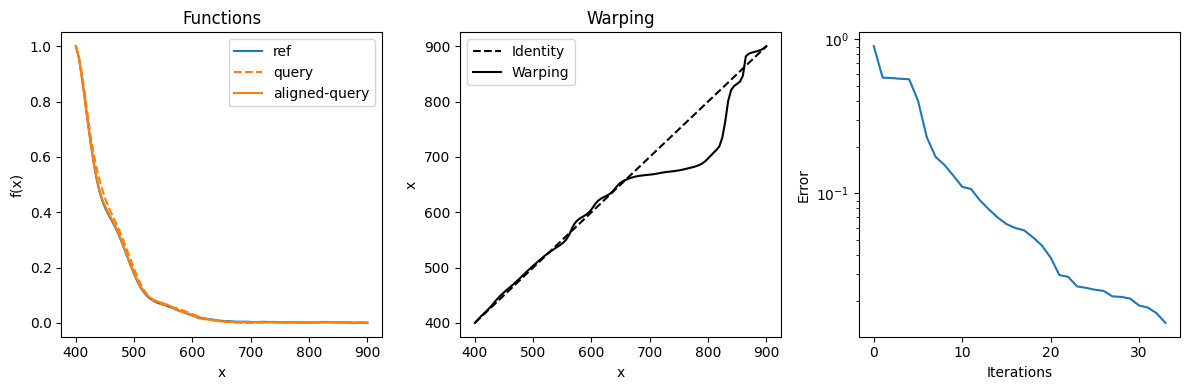

In [27]:
from apdist.torch import plot_warping as plot_warping_torch
from apdist.torch import AmplitudePhaseDistance as torch_apdist 
import torch 

optim_kwargs = {"n_iters":50, 
                "n_basis":15, 
                "n_layers":15,
                "domain_type":"linear",
                "basis_type":"palais",
                "n_restarts":50,
                "lr":1e-1,
                "n_domain":len(expt.t)
                }
amplitude, phase, output = torch_apdist(torch.from_numpy(expt.t), # all the inputs should be torch.Tensor
                                        torch.from_numpy(f_ref), 
                                        torch.from_numpy(f_query), 
                                        **optim_kwargs
                                        )

print("Amplitude : %2.4f, Phase : %2.4f"%(amplitude, phase))
plot_warping_torch(expt.wl, f_ref, f_query, output)